<a href="https://colab.research.google.com/github/Zekiye-Y/capstone-project/blob/main/Capstone_Project_kits23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##bold text Useful Links
- https://keras.io/examples/vision/3D_image_classification/
- https://developer.nvidia.com/blog/building-medical-3d-image-segmentation-using-jupyter-notebooks-from-the-ngc-catalog/
- https://nipy.org/nibabel/gettingstarted.html
- https://github.com/frankkramer-lab/MIScnn/tree/master

## SETUP
## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Necessary Modules

In [3]:
cd ../root/

/root


In [4]:
!git clone https://github.com/frankkramer-lab/MIScnn

Cloning into 'MIScnn'...
remote: Enumerating objects: 3497, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 3497 (delta 19), reused 16 (delta 8), pack-reused 3453
Receiving objects: 100% (3497/3497), 136.24 MiB | 40.51 MiB/s, done.
Resolving deltas: 100% (2382/2382), done.


In [5]:
cd /root/MIScnn

/root/MIScnn


In [ ]:
!python setup.py install

In [ ]:
#!pip install SimpleITK

In [ ]:
#!pip install nifti2gif

In [ ]:
!pip install batchgenerators

In [2]:
import os
import cv2
import shutil

import keras
import tensorflow as tf

import miscnn

import nibabel as nib
#import SimpleITK as sitk
import imageio
#import nifti2gif.core as nifti2gif

#import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Unzip Kits23-Sample from Google Drive

In [ ]:
!unzip '/content/drive/MyDrive/kits23-sample.zip' -d '/content/drive/MyDrive/'

## Rename Case Numbers for Downstream Processing
Here I have to remove the '0's from the cases as it causes issues in the DataGenerator below. Freddy

In [33]:
def remove_zeros_from_folder_names():
    current_directory = "/content/drive/MyDrive/kits23-sample/dataset/"
    folder_names = os.listdir(current_directory)

    for folder_name in folder_names:
        if folder_name == "case_":
          new_folder_name = "case_0"
          old_path = os.path.join(current_directory, folder_name)
          new_path = os.path.join(current_directory, new_folder_name)
          os.rename(old_path, new_path)
        if folder_name == "case_00000":
          new_folder_name = "case_0"
          old_path = os.path.join(current_directory, folder_name)
          new_path = os.path.join(current_directory, new_folder_name)
          os.rename(old_path, new_path)
        else:
          new_folder_name = folder_name.replace('0', '')
        if new_folder_name != folder_name:
            old_path = os.path.join(current_directory, folder_name)
            new_path = os.path.join(current_directory, new_folder_name)
            os.rename(old_path, new_path)
            print(f"Renamed '{folder_name}' to '{new_folder_name}'")

remove_zeros_from_folder_names()

## View Image Instance
Note: the `visualize.py` script in conjunction with `util.py` will return a series of .png images in your chosen directory. The images will have the segmentation overlayed. I will need to work out a way to remove the segmentation so we can train on the images alone and with the segmentation as the ground-truth. Please see below for an example.

We might be able to modify the `visualize.py` file to just return a series of images without segmentation. In addition, we might be able to change the plane ('axial', saggital, 'coronal').Freddy


---



 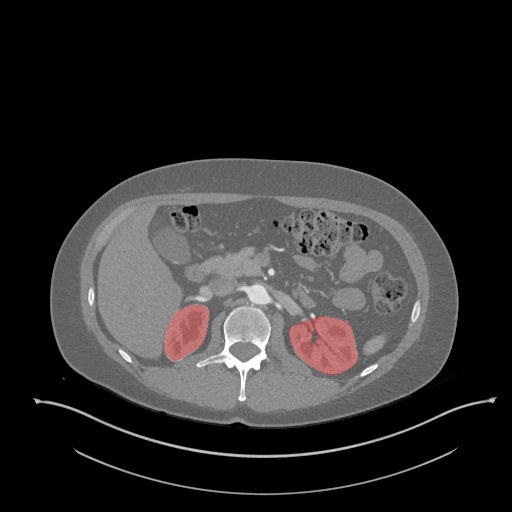

In [ ]:
# -c CaseNumber
# -d Directory to place .png files
# -p Plane ['axial', 'sagittal', 'coronal']
!python visualize.py -c case_0 -d "/content/drive/MyDrive/kits23-sample/dataset/case_0/png_axial_view"

/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:81: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  vol = vol.get_data()
/content/drive/MyDrive/kits23-sample/kits23/annotation/visualize.py:82: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  seg = seg.get_data()


## Alternative Viewing of Imaging

In [4]:
sampleFilepath = os.path.join("/content/drive/MyDrive/kits23-sample/dataset/", 'case_1/imaging.nii.gz')

In [5]:
sampleImage = nib.load(sampleFilepath)

In [6]:
sampleImageData = sampleImage.get_fdata()

In [17]:
sampleImage.shape

(50, 512, 512)

In [19]:
sampleImage.get_data_dtype()

dtype('<f8')

In [38]:
type(sampleImageData)

numpy.ndarray

In [20]:
print(sampleImage)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 512, 512)
affine: 
[[ 0.         0.        -0.7578125  0.       ]
 [ 0.        -0.7578125  0.         0.       ]
 [-3.         0.         0.         0.       ]
 [ 0.         0.         0.         1.       ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  50 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1.        3.        0.7578125 0.7578125 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
gl

In [24]:
# https://nipy.org/nibabel/coordinate_systems.html

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Centre Slices for Image')

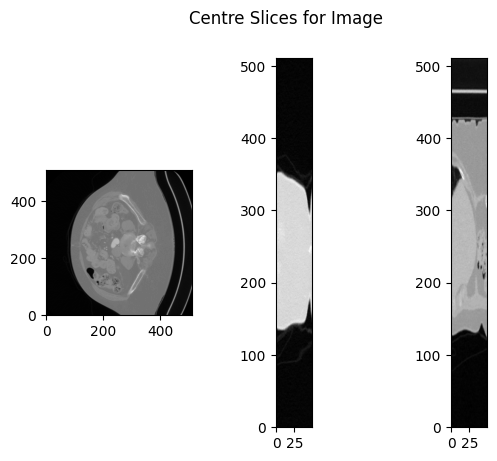

In [28]:
slice_0 = sampleImageData[49, :, :]
slice_1 = sampleImageData[:, 100, :]
slice_2 = sampleImageData[:, :, 100]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Centre Slices for Image")

***Thanks to ChatGPT***

*Can you explain this shape to me: ndarray with shape (50, 512, 512)*

The shape (50, 512, 512) describes a three-dimensional NumPy ndarray (array) with the following characteristics:

The first dimension (axis 0) has a size of 50: This means that the array contains 50 "slices" or "layers" of data. You can think of these as individual 2D images or grids stacked on top of each other along the first dimension. Each of these 2D slices has dimensions of 512x512.

The second dimension (axis 1) has a size of 512: This represents the number of rows in each 2D slice. Each 2D slice has 512 rows.

The third dimension (axis 2) also has a size of 512: This represents the number of columns in each 2D slice. Each 2D slice has 512 columns.

So, in summary, you have a 3D ndarray with 50 slices, and each slice is a 2D grid with dimensions of 512x512. This kind of data structure is often used to represent volumetric or multi-slice images, where each 2D slice represents a "slice" of the overall 3D volume, and you can access individual slices along the first dimension.

(50, 512, 512)


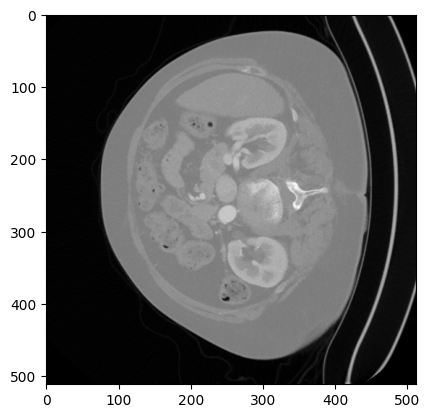

In [34]:
# https://peerherholz.github.io/workshop_weizmann/data/image_manipulation_nibabel.html

plt.imshow(sampleImageData[sampleImageData.shape[0] // 2, :, :].T, cmap='Greys_r')
print(sampleImageData.shape)

## Viewing of Segmentation Data

In [5]:
sampleFilepath_Seg = os.path.join("/content/drive/MyDrive/kits23-sample/dataset/", 'case_1/segmentation.nii.gz')

In [6]:
sampleCase_Seg = nib.load(sampleFilepath_Seg)

In [10]:
sampleCase_SegData = sampleCase_Seg.get_fdata()

In [7]:
sampleCase_Seg.shape

(50, 512, 512)

In [12]:
print(sampleCase_Seg)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 512, 512)
affine: 
[[ 0.         0.        -0.7578125  0.       ]
 [ 0.        -0.7578125  0.         0.       ]
 [-3.         0.         0.         0.       ]
 [ 0.         0.         0.         1.       ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  50 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.        3.        0.7578125 0.7578125 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax

(50, 512, 512)


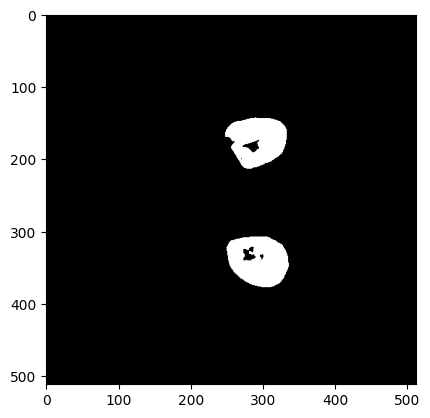

In [13]:
plt.imshow(sampleCase_SegData[sampleCase_SegData.shape[0] // 2, :, :].T, cmap='Greys_r')
print(sampleCase_SegData.shape)

## Loading of Data
With thanks to the following Kaggle notebook which has given us a leg up at extracting the .nii.gz files into a training format for the model: https://www.kaggle.com/code/sowmyasamantula/3d-mri-brain-tumor-segmentation-u-net. Freddy

In [4]:
TRAIN_DATASET_PATH = "/content/drive/MyDrive/kits23-sample/dataset"

In [5]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [6]:
print(f"Number of Training Cases: {len(train_ids)}")
print(f"Number of Validation Cases: {len(val_ids)}")
print(f"Number of Testing Cases: {len(test_ids)}")

Number of Training Cases: 26
Number of Validation Cases: 8
Number of Testing Cases: 5


In [7]:
print(train_ids)
print(val_ids)
print(test_ids)

['case_583', 'case_25', 'case_4', 'case_588', 'case_28', 'case_3', 'case_27', 'case_23', 'case_8', 'case_581', 'case_13', 'case_29', 'case_585', 'case_2', 'case_7', 'case_1', 'case_21', 'case_6', 'case_586', 'case_14', 'case_16', 'case_584', 'case_26', 'case_15', 'case_11', 'case_5']
['case_0', 'case_58', 'case_579', 'case_9', 'case_19', 'case_12', 'case_22', 'case_18']
['case_17', 'case_582', 'case_587', '.ipynb_checkpoints', 'case_24']


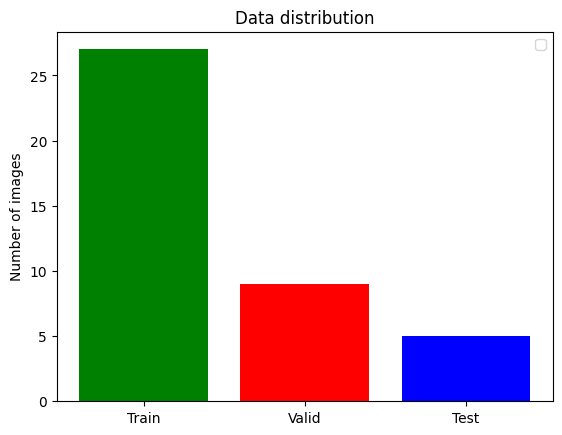

In [18]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

## Construction of DataGenerator

In [37]:
IMG_SIZE = 512
VOLUME_SLICES = 350
VOLUME_START_AT = 85

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    # I'm assumming because we have a single grayscale CT scan, n_channels = 1
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        # I believe there's only three classes = 1. kidney, 2. tumour, 3. cyst
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 3))


        # Generate data
        for c, i in enumerate(Batch_ids):
            data_path = os.path.join(TRAIN_DATASET_PATH, f'case_{c}/imaging.nii.gz');
            image = nib.load(data_path).get_fdata()

            data_path = os.path.join(TRAIN_DATASET_PATH, f'case_{c}/segmentation.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # NOT SURE WHAT THIS CODE IS FOR!!
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 3);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [38]:
print("Training Gen Length:", training_generator.__len__())
print("Validation Gen Length:", valid_generator.__len__())
print("Testing Gen Length:", test_generator.__len__())

Training Gen Length: 6
Validation Gen Length: 2
Testing Gen Length: 1


In [ ]:
counter = 0

print("\n-- TRAINING DATA -- ")
for x,y in training_generator.__iter__():
  if counter == 1:
    break
  print(type(x))
  print(f"Shape X: ({len(x)}, {len(x[0]), len(x[1]), len(x[2]), len(x[3])})")
  print(f"Shape Y: ({y.shape}\n")
  counter += 1

# Alternative Data Generator using MIScnn API
Here I've found a library that specialises in Medical Image Segmentation using CNN's (MIScnn). The authors have used this API to work with the KiTs19 dataset (https://github.com/frankkramer-lab/MIScnn/blob/master/examples/KiTS19.ipynb). The API has the UNet architecture already built in, with additional features including Data-Loading and Augmentation of images for a robust model.

In [3]:
from miscnn.data_loading.interfaces.nifti_io import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO

interface = NIFTI_interface(pattern="case_[0-9]*",
                            channels = 1,
                            classes = 3)

In [4]:
data_path = "/content/drive/MyDrive/kits23-sample/dataset"
data_io = Data_IO(interface, data_path)

In [5]:
sample_list = data_io.get_indiceslist()
sample_list.sort()
print("All samples: " + str(sample_list))

All samples: ['case_0', 'case_1', 'case_11', 'case_12', 'case_13', 'case_14', 'case_15', 'case_16', 'case_17', 'case_18', 'case_19', 'case_2', 'case_21', 'case_22', 'case_23', 'case_24', 'case_25', 'case_26', 'case_27', 'case_28', 'case_29', 'case_3', 'case_4', 'case_5', 'case_579', 'case_58', 'case_581', 'case_582', 'case_583', 'case_584', 'case_585', 'case_586', 'case_587', 'case_588', 'case_6', 'case_7', 'case_8', 'case_9']
